In [108]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [109]:
test = np.full((4, 512, 512, 1), 255)


In [110]:
test[0].shape

(512, 512, 1)

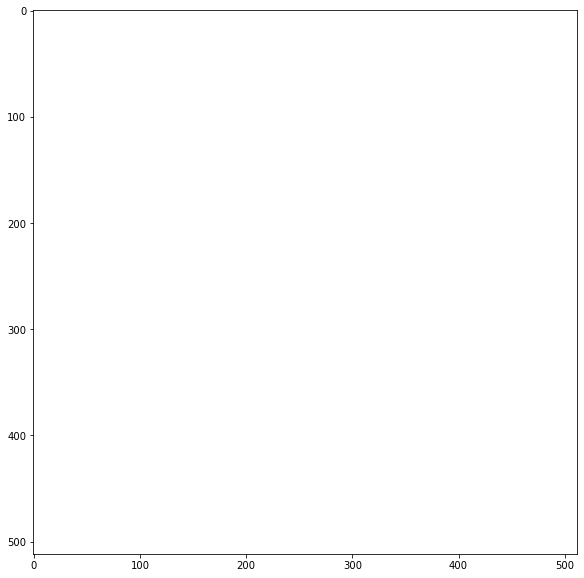

In [111]:
plt.figure(figsize=(10,10))
plt.imshow(test[0], vmin=0, vmax=255, cmap="gray")
plt.gray()

In [112]:
PATCHING_SIZE = 64
ksize_rows = PATCHING_SIZE
ksize_cols = PATCHING_SIZE
strides_rows = PATCHING_SIZE
strides_cols = PATCHING_SIZE
overlap = 8

ksizes = [1, ksize_rows, ksize_cols, 1]
strides = [1, strides_rows-overlap, strides_cols-overlap, 1]
rates = [1, 1, 1, 1]
padding = "VALID"

patches = tf.image.extract_patches(images = test, sizes = ksizes, strides = strides, rates=rates, padding=padding)

In [113]:
patches.shape

TensorShape([4, 9, 9, 4096])

In [114]:
patches = np.reshape(patches, [4 * 9 * 9, 64, 64, 1])

In [115]:
patches.shape

(324, 64, 64, 1)

In [116]:
def reconstruct(patches, width, height, noriginal, dims, overlap):
    original = np.zeros((noriginal, width, height, dims))
    (npatches, pwidth, pheight, pchannel) = patches.shape
    nwidth = int(width / pwidth)
    nwidth = int(nwidth + nwidth*overlap/pwidth)
    nheight = int(height / pheight)
    nheight = int(nheight + nheight*overlap/pheight)
    for i in range(noriginal):
        for j in range(nheight):
            for k in range(nwidth):
                insert = patches[((j * nheight) + k)+(i*nwidth*nheight)]
                pixels = overlap // 2
                hstart = 2*(j-1) + 1
                hend = 2*j + 1
                wstart = 2*(k-1) + 1
                wend = 2*k + 1
                if(j == 0 and k == 0): #top left
                    insert = insert[:-pixels, :-pixels]
                    original[i, j*pheight:(j+1)*pheight - pixels, k*pwidth:(k+1)*pwidth - pixels] = insert
                elif(k == 0 and j == nheight - 1): #bottom left
                    insert = insert[pixels:, :-pixels]
                    original[i, j*pheight - hstart*pixels:(j+1)*pheight - 2*j*pixels, k*pwidth:(k+1)*pwidth - pixels] = insert
                elif(j == 0 and k == nwidth - 1): #top right 
                    insert = insert[:-pixels, pixels:]
                    original[i, j*pheight:(j+1)*pheight - pixels, k*pwidth - wstart*pixels: (k+1)*pwidth - 2*k*pixels] = insert
                elif(j == nheight - 1 and k == nwidth - 1):
                    insert = insert[pixels:, pixels:]
                    original[i, j*pheight - hstart*pixels: (j+1)*pheight - 2*j*pixels, k*pwidth - wstart*pixels: (k+1)*pwidth - 2*k*pixels] = insert
                elif(k == 0): #left border
                    insert = insert[pixels:-pixels, :-pixels]
                    original[i, j*pheight - hstart*pixels:(j+1)*pheight - hend*pixels, k*pwidth:(k+1)*pwidth - pixels] = insert
                elif(j == 0 ): #top border 
                    insert = insert[:-pixels, pixels:-pixels]
                    original[i, j*pheight:(j+1)*pheight - pixels, k*pwidth - wstart*pixels: (k+1)*pwidth - wend*pixels] = insert
                elif(k == nwidth - 1): #right border
                    insert = insert[pixels: -pixels, pixels:]
                    original[i, j*pheight - hstart*pixels : (j+1)*pheight - hend*pixels, k*pwidth - wstart*pixels: (k+1)*pwidth - 2*k*pixels] = insert
                elif(j == nheight - 1): #bottom border
                    insert = insert[pixels:, pixels:-pixels]
                    original[i, j*pheight - hstart*pixels:(j+1)*pheight - 2*j*pixels, k*pwidth - wstart*pixels: (k+1)*pwidth - wend*pixels] = insert
                else:
                    insert = insert[pixels:-pixels, pixels:-pixels]
                    original[i, j*pheight - hstart*pixels:(j+1)*pheight - hend*pixels, k*pwidth - wstart*pixels: (k+1)*pwidth - wend*pixels] = insert
                

    return original

In [117]:
recon = reconstruct(patches, 512, 512, 4, 1, overlap)

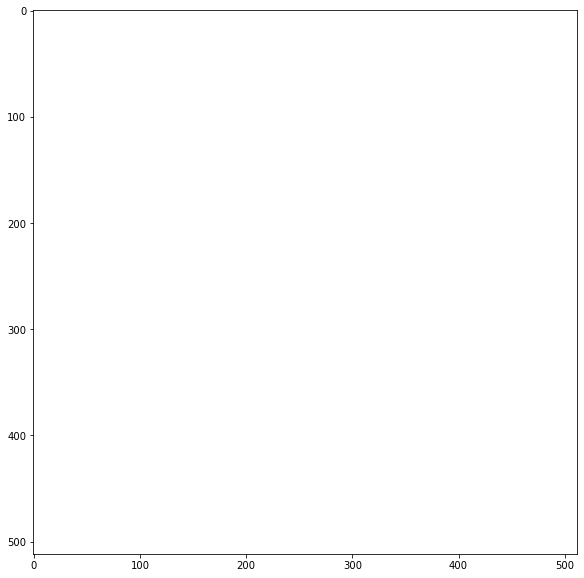

In [118]:
plt.figure(figsize=(10, 10))
plt.imshow(recon[2], vmin=0, vmax=255)
plt.gray()